In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic, NMF, BaselineOnly
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from collections import defaultdict
import sys
import warnings
warnings.filterwarnings('ignore')

# 한국어 폰트 설정 (시스템에 따라 조정 필요)
plt.rcParams['font.family'] = ['Malgun Gothic', 'AppleGothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# 전역 변수 설정
data = None
trainset = None
testset = None
algorithms = {}
results = {}

print("라이브러리 임포트 완료")
print(f"Python 버전: {sys.version}")
print(f"Pandas 버전: {pd.__version__}")
print(f"NumPy 버전: {np.__version__}")
print(f"Matplotlib 버전: {plt.matplotlib.__version__}")
print(f"Seaborn 버전: {sns.__version__}")


라이브러리 임포트 완료
Python 버전: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Pandas 버전: 1.5.3
NumPy 버전: 1.23.5
Matplotlib 버전: 3.7.0
Seaborn 버전: 0.12.2


In [2]:
# 데이터 로드 함수
def load_recommendation_data(ratings_file):
    global data, trainset, testset
    
    # ratings.dat 파일 형식: UserID::MovieID::Rating::Timestamp
    ratings_df = pd.read_csv(
        ratings_file, 
        sep='::', 
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        engine='python'
    )
    
    print(f"데이터 로드 완료: {len(ratings_df):,}개의 평점")
    print(f"사용자 수: {ratings_df['user_id'].nunique():,}명")
    print(f"영화 수: {ratings_df['movie_id'].nunique():,}개")
    print(f"평점 분포:\n{ratings_df['rating'].value_counts().sort_index()}")
        
    # Surprise 라이브러리용 데이터 준비
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
        
    # 80:20 비율로 데이터 분할
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
        
    return ratings_df

# 알고리즘 초기화 함수
def initialize_algorithms():
    """추천 알고리즘 초기화"""
    global algorithms
    
    algorithms = {
        'SVD': SVD(n_factors=100, n_epochs=20, random_state=42),
        'KNNBasic': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True}),
        'NMF': NMF(n_factors=50, n_epochs=50, random_state=42),
        'BaselineOnly': BaselineOnly()
    }
        
    print(f"초기화된 알고리즘: {list(algorithms.keys())}")

# 데이터 로드 및 알고리즘 초기화 실행
print("=== MovieLens 1M 데이터 로드 ===")
ratings_df = load_recommendation_data('ratings.dat')
print("\n=== 알고리즘 초기화 ===")
initialize_algorithms()


=== MovieLens 1M 데이터 로드 ===
데이터 로드 완료: 1,000,209개의 평점
사용자 수: 6,040명
영화 수: 3,706개
평점 분포:
1     56174
2    107557
3    261197
4    348971
5    226310
Name: rating, dtype: int64

=== 알고리즘 초기화 ===
초기화된 알고리즘: ['SVD', 'KNNBasic', 'NMF', 'BaselineOnly']


In [ ]:
# 5-폴드 교차 검증 평가 함수
def cross_validation_evaluation():
    global results
    
    cv_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} 평가 중...")
        cv_result = cross_validate(
            algorithm, 
            data, 
            measures=['RMSE', 'MAE'], 
            cv=5, 
            verbose=False
        )
            
        cv_results[name] = {
            'RMSE': {
                'mean': cv_result['test_rmse'].mean(),
                'std': cv_result['test_rmse'].std()
            },
            'MAE': {
                'mean': cv_result['test_mae'].mean(),
                'std': cv_result['test_mae'].std()
            }
        }
        
    results['cross_validation'] = cv_results
    return cv_results

# Top-N 추천 관련 함수들
def get_top_n_recommendations(predictions, n=10, threshold=4.0):
    """상위 N개 추천 목록 생성"""
    top_n = defaultdict(list)
        
    for uid, iid, true_r, est, _ in predictions:
        if est >= threshold:
            top_n[uid].append((iid, est))
        
    # 각 사용자별로 예측 평점 기준 상위 N개 추출
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

def calculate_precision_recall(predictions, threshold=4.0, k=10):
    """Precision@K와 Recall@K 계산"""
    # 실제 선호도가 높은 아이템 (평점 4.0 이상)
    user_relevant_items = defaultdict(set)
        
    for uid, iid, true_r, est, _ in predictions:
        if true_r >= threshold:
            user_relevant_items[uid].add(iid)
        
    # Top-K 추천 목록
    top_k_recs = get_top_n_recommendations(predictions, n=k, threshold=threshold)
        
    precisions = []
    recalls = []
        
    for uid in user_relevant_items:
        if uid in top_k_recs:
            recommended_items = set([iid for iid, _ in top_k_recs[uid]])
            relevant_items = user_relevant_items[uid]
                
            if len(recommended_items) > 0:
                precision = len(recommended_items & relevant_items) / len(recommended_items)
                precisions.append(precision)
                
            if len(relevant_items) > 0:
                recall = len(recommended_items & relevant_items) / len(relevant_items)
                recalls.append(recall)
        
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
        
    return avg_precision, avg_recall

def evaluate_topn_recommendations():
    """Top-10 추천 평가"""
    global results
    
    topn_results = {}
        
    for name, algorithm in algorithms.items():
        print(f"  - {name} Top-10 추천 평가 중...")
            
        # 알고리즘 학습
        algorithm.fit(trainset)
            
        # 테스트 세트 예측
        predictions = algorithm.test(testset)
            
        # Precision@10, Recall@10 계산
        precision, recall = calculate_precision_recall(predictions, threshold=4.0, k=10)
            
        topn_results[name] = {
            'Precision@10': precision,
            'Recall@10': recall
        }
        
    results['topn_evaluation'] = topn_results
    return topn_results

# 평가 실행
print("=== 5-폴드 교차 검증 실행 ===")
cv_results = cross_validation_evaluation()
print("\n=== Top-10 추천 성능 평가 ===")
topn_results = evaluate_topn_recommendations()


=== 5-폴드 교차 검증 실행 ===
  - SVD 평가 중...
  - KNNBasic 평가 중...



                    영화 추천 시스템 성능 분석 결과

1. 5-폴드 교차 검증 결과:
------------------------------------------------------------
Algorithm       RMSE            MAE            
------------------------------------------------------------
SVD             0.8732          0.6854         
KNNBasic        0.9769          0.7711         
NMF             1.0254          0.7792         
BaselineOnly    0.9087          0.7195         

2. Top-10 추천 성능:
------------------------------------------------------------
Algorithm       Precision@10    Recall@10      
------------------------------------------------------------
SVD             0.8600          0.4028         
KNNBasic        0.8087          0.3975         
NMF             0.7847          0.5402         
BaselineOnly    0.8408          0.3905         

3. 최적 알고리즘 추천:
------------------------------------------------------------
RMSE 기준 최적: SVD (RMSE: 0.8732)
MAE 기준 최적: SVD (MAE: 0.6854)
Precision@10 기준 최적: SVD (Precision: 0.8600)
Recall@10 기준 최적: N

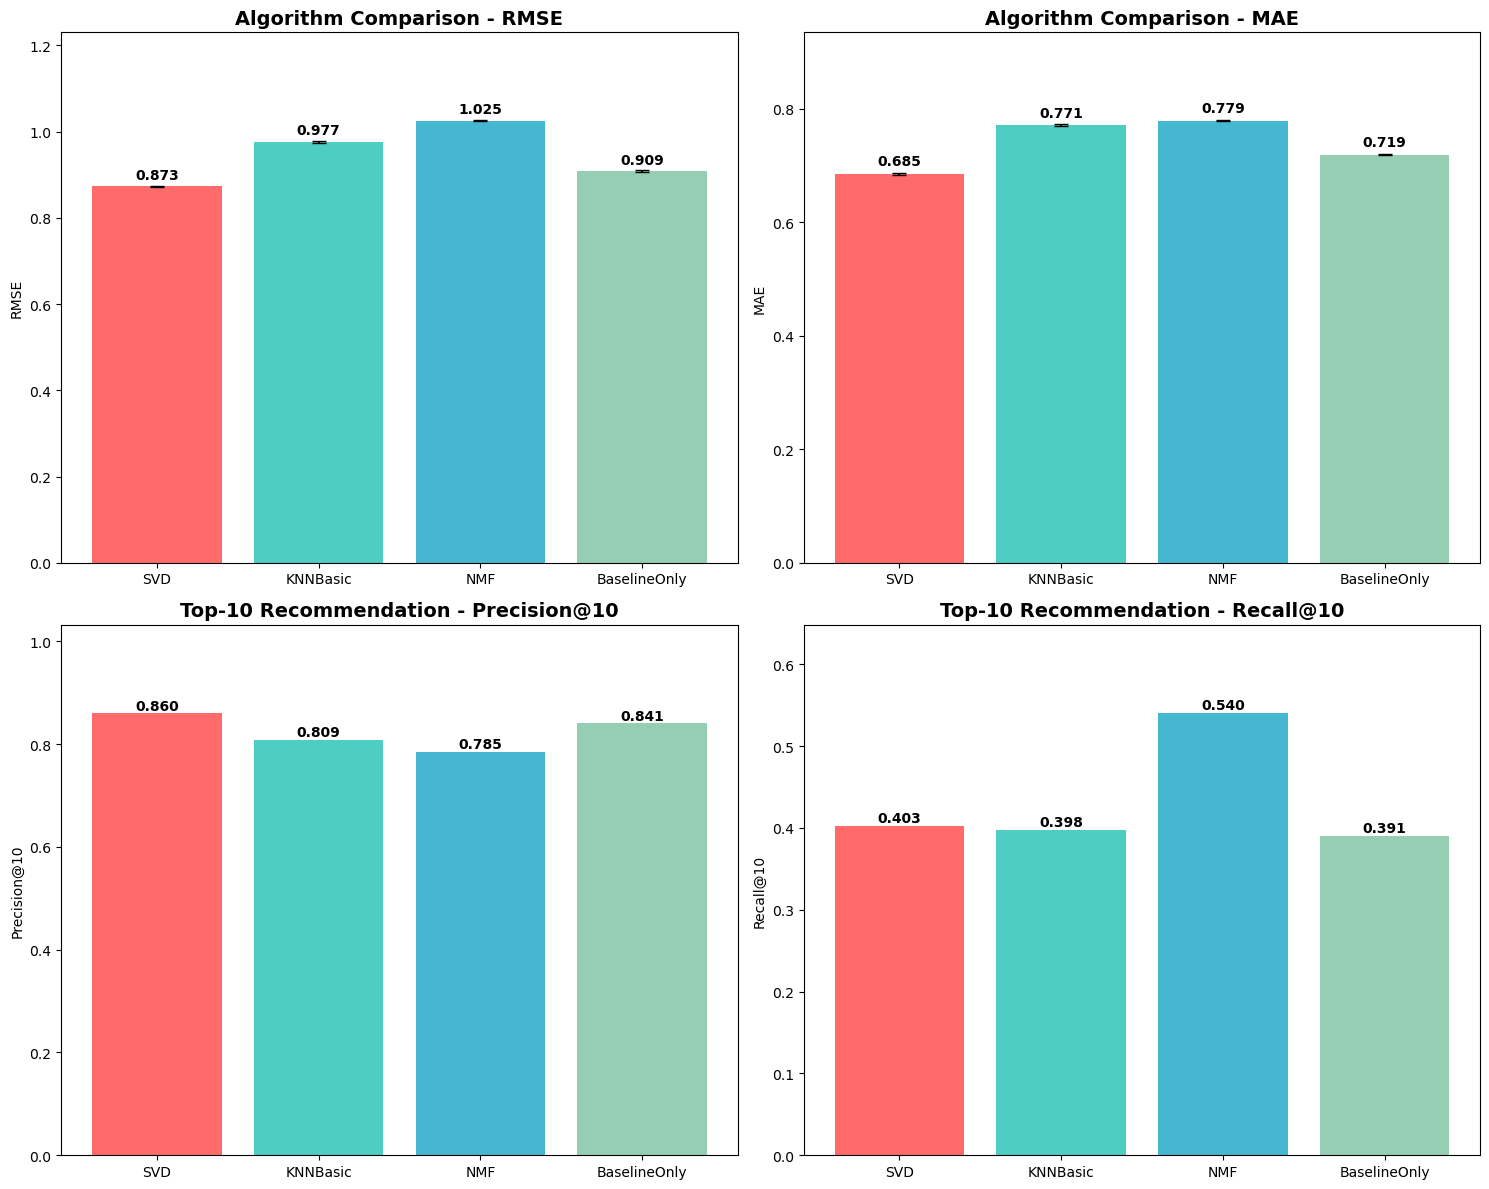

In [ ]:
# 결과 시각화 함수
def visualize_algorithm_results():
    """알고리즘 비교 결과 시각화"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
    # RMSE 비교
    algorithm_names = list(results['cross_validation'].keys())
    rmse_means = [results['cross_validation'][alg]['RMSE']['mean'] for alg in algorithm_names]
    rmse_stds = [results['cross_validation'][alg]['RMSE']['std'] for alg in algorithm_names]
        
    bars1 = ax1.bar(algorithm_names, rmse_means, yerr=rmse_stds, capsize=5, 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax1.set_title('Algorithm Comparison - RMSE', fontsize=14, fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_ylim(0, max(rmse_means) * 1.2)
        
    for bar, mean in zip(bars1, rmse_means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # MAE 비교
    mae_means = [results['cross_validation'][alg]['MAE']['mean'] for alg in algorithm_names]
    mae_stds = [results['cross_validation'][alg]['MAE']['std'] for alg in algorithm_names]
        
    bars2 = ax2.bar(algorithm_names, mae_means, yerr=mae_stds, capsize=5,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Algorithm Comparison - MAE', fontsize=14, fontweight='bold')
    ax2.set_ylabel('MAE')
    ax2.set_ylim(0, max(mae_means) * 1.2)
        
    for bar, mean in zip(bars2, mae_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    # Precision@10 비교
    precision_values = [results['topn_evaluation'][alg]['Precision@10'] for alg in algorithm_names]
        
    bars3 = ax3.bar(algorithm_names, precision_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax3.set_title('Top-10 Recommendation - Precision@10', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Precision@10')
    ax3.set_ylim(0, max(precision_values) * 1.2 if max(precision_values) > 0 else 1)
        
    for bar, precision in zip(bars3, precision_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{precision:.3f}', ha='center', va='bottom', fontweight='bold')
        
    # Recall@10 비교
    recall_values = [results['topn_evaluation'][alg]['Recall@10'] for alg in algorithm_names]
        
    bars4 = ax4.bar(algorithm_names, recall_values,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax4.set_title('Top-10 Recommendation - Recall@10', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Recall@10')
    ax4.set_ylim(0, max(recall_values) * 1.2 if max(recall_values) > 0 else 1)
        
    for bar, recall in zip(bars4, recall_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

# 상세 결과 출력 함수
def print_algorithm_results():
    """상세한 알고리즘 비교 결과 출력"""
    print("\n" + "="*80)
    print("                    영화 추천 시스템 성능 분석 결과")
    print("="*80)
    
    # 교차 검증 결과
    print("\n1. 5-폴드 교차 검증 결과:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'RMSE':<15} {'MAE':<15}")
    print("-" * 60)
    
    for alg_name in results['cross_validation']:
        rmse = results['cross_validation'][alg_name]['RMSE']['mean']
        mae = results['cross_validation'][alg_name]['MAE']['mean']
        print(f"{alg_name:<15} {rmse:<15.4f} {mae:<15.4f}")
    
    # Top-N 추천 결과
    print("\n2. Top-10 추천 성능:")
    print("-" * 60)
    print(f"{'Algorithm':<15} {'Precision@10':<15} {'Recall@10':<15}")
    print("-" * 60)
    
    for alg_name in results['topn_evaluation']:
        precision = results['topn_evaluation'][alg_name]['Precision@10']
        recall = results['topn_evaluation'][alg_name]['Recall@10']
        print(f"{alg_name:<15} {precision:<15.4f} {recall:<15.4f}")

    # 최적 알고리즘 추천
    print("\n3. 최적 알고리즘 추천:")
    print("-" * 60)
    
    best_rmse_alg = min(results['cross_validation'].items(), 
                       key=lambda x: x[1]['RMSE']['mean'])
    print(f"RMSE 기준 최적: {best_rmse_alg[0]} (RMSE: {best_rmse_alg[1]['RMSE']['mean']:.4f})")
    
    best_mae_alg = min(results['cross_validation'].items(), 
                      key=lambda x: x[1]['MAE']['mean'])
    print(f"MAE 기준 최적: {best_mae_alg[0]} (MAE: {best_mae_alg[1]['MAE']['mean']:.4f})")
    
    best_precision_alg = max(results['topn_evaluation'].items(), 
                            key=lambda x: x[1]['Precision@10'])
    print(f"Precision@10 기준 최적: {best_precision_alg[0]} (Precision: {best_precision_alg[1]['Precision@10']:.4f})")
    
    best_recall_alg = max(results['topn_evaluation'].items(), 
                         key=lambda x: x[1]['Recall@10'])
    print(f"Recall@10 기준 최적: {best_recall_alg[0]} (Recall: {best_recall_alg[1]['Recall@10']:.4f})")

# 결과 출력 및 시각화
print_algorithm_results()
visualize_algorithm_results()


In [3]:
# CRM 분석용 데이터 로드 및 전처리
print("\n" + "="*80)
print("                    CRM 분석을 위한 데이터 준비")
print("="*80)

# 사용자 데이터 로드
users = pd.read_csv('users.dat', sep='::', engine='python', 
                    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')

# 영화 데이터 로드
movies = pd.read_csv('movies.dat', sep='::', engine='python', 
                     names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# 연령대 코드 매핑
age_map = {1: '18세 미만', 18: '18-24세', 25: '25-34세', 35: '35-44세', 
           45: '45-49세', 50: '50-55세', 56: '56세 이상'}
users['Age'] = users['Age'].map(age_map)

# 직업 코드 매핑
occupation_map = {0: '기타/미지정', 1: '학계/교육자', 2: '예술가', 3: '사무/행정', 
                  4: '대학원생', 5: '고객 서비스', 6: '의사/의료', 7: '경영/관리', 
                  8: '농업', 9: '주부', 10: 'K-12 학생', 11: '변호사', 12: '프로그래머', 
                  13: '은퇴', 14: '판매/마케팅', 15: '과학자', 16: '자영업', 17: '기술자/엔지니어', 
                  18: '장인/기술자', 19: '실업자', 20: '작가'}
users['Occupation'] = users['Occupation'].map(occupation_map)

# 장르를 리스트로 분리
movies['Genres'] = movies['Genres'].str.split('|')

# 장르를 개별 행으로 확장
movies_exploded = movies.explode('Genres')

# 평점, 사용자, 영화 데이터를 병합
merged_data = ratings_df.rename(columns={'user_id': 'UserID', 'movie_id': 'MovieID', 'rating': 'Rating'})
merged_data = merged_data.merge(users, on='UserID').merge(movies_exploded, on='MovieID')

print(f"CRM 분석용 데이터 준비 완료")
print(f"총 레코드 수: {len(merged_data):,}")
print(f"사용자 수: {merged_data['UserID'].nunique():,}명")
print(f"영화 수: {merged_data['MovieID'].nunique():,}개")
print(f"장르 수: {merged_data['Genres'].nunique():,}개")



                    CRM 분석을 위한 데이터 준비


NameError: name 'ratings_df' is not defined

In [2]:
# 인구통계 분석
print("\n=== 성별, 연령대, 직업군별 평점 패턴 분석 ===")

# 성별 및 연령대별 평균 평점 계산
group_stats = merged_data.groupby(['Gender', 'Age'])['Rating'].agg(['mean', 'count']).reset_index()
pivot_table = group_stats.pivot(index='Age', columns='Gender', values='mean')

# 시각화를 위한 figure 설정
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 성별 및 연령대별 평균 평점 히트맵
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f', ax=ax1)
ax1.set_title('성별 및 연령대별 평균 평점', fontsize=14, fontweight='bold')
ax1.set_xlabel('성별')
ax1.set_ylabel('연령대')

# 2. 직업군별 평점 분포 박스플롯
# 상위 10개 직업군만 표시 (가독성을 위해)
top_occupations = merged_data['Occupation'].value_counts().head(10).index
top_occupation_data = merged_data[merged_data['Occupation'].isin(top_occupations)]

sns.boxplot(x='Occupation', y='Rating', data=top_occupation_data, ax=ax2)
ax2.set_title('주요 직업군별 평점 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('직업군')
ax2.set_ylabel('평점')
ax2.tick_params(axis='x', rotation=45)

# 3. 성별별 평점 분포
sns.violinplot(x='Gender', y='Rating', data=merged_data, ax=ax3)
ax3.set_title('성별 평점 분포', fontsize=14, fontweight='bold')
ax3.set_xlabel('성별')
ax3.set_ylabel('평점')

# 4. 연령대별 평점 수 분포
age_rating_counts = merged_data.groupby('Age')['Rating'].count().sort_values(ascending=False)
age_rating_counts.plot(kind='bar', ax=ax4, color='lightcoral')
ax4.set_title('연령대별 평점 수', fontsize=14, fontweight='bold')
ax4.set_xlabel('연령대')
ax4.set_ylabel('평점 수')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 상세 통계 출력
print("\n성별 및 연령대별 평균 평점 및 평점 수:")
print(group_stats.round(3))

# 직업군별 통계
print("\n주요 직업군별 평점 통계:")
occupation_stats = merged_data.groupby('Occupation')['Rating'].agg(['mean', 'count', 'std']).round(3)
occupation_stats = occupation_stats.sort_values('count', ascending=False).head(10)
print(occupation_stats)



=== 성별, 연령대, 직업군별 평점 패턴 분석 ===


NameError: name 'merged_data' is not defined


=== 연령대별 장르 선호도 분석 ===


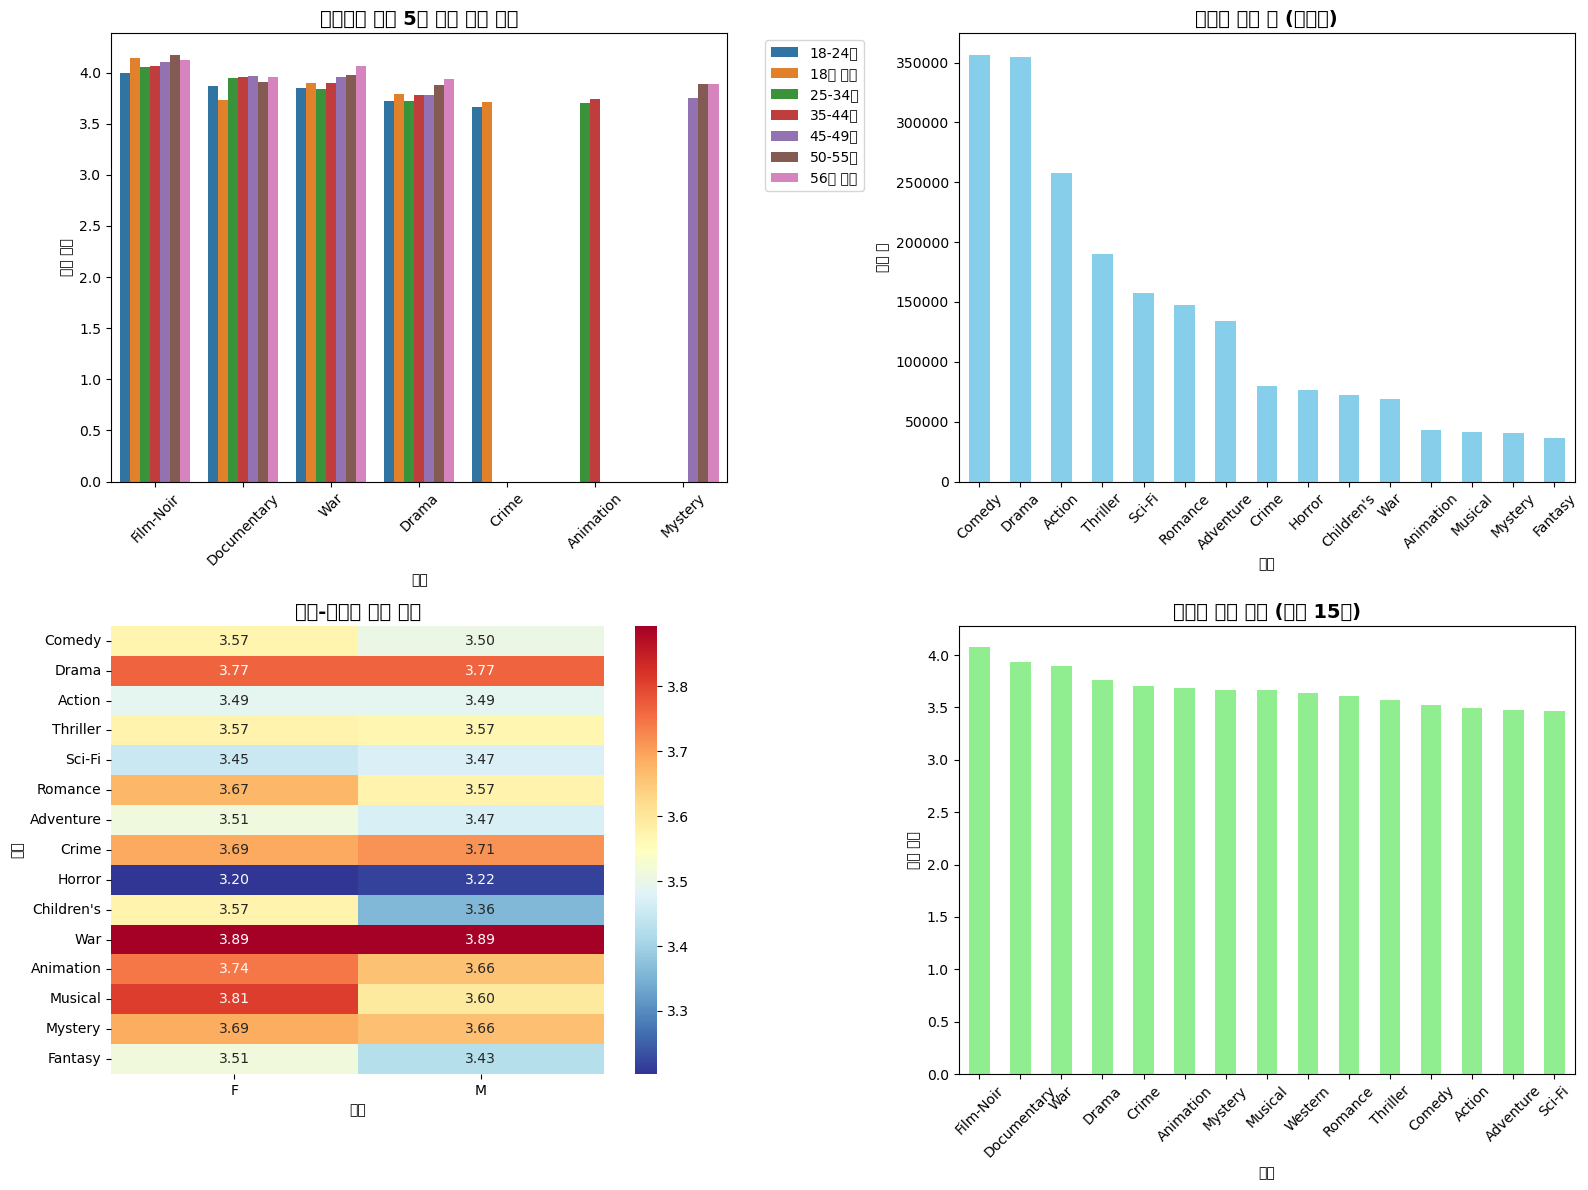


연령대별 상위 5개 선호 장르:

18-24세:
     Genres  mean  count
  Film-Noir 3.997   2280
Documentary 3.866   1081
        War 3.853  10874
      Drama 3.722  58104
      Crime 3.668  15373

18세 미만:
     Genres  mean  count
  Film-Noir 4.145    330
        War 3.895   1578
      Drama 3.795   7483
Documentary 3.731    130
      Crime 3.710   1701

25-34세:
     Genres  mean  count
  Film-Noir 4.059   6539
Documentary 3.947   3489
        War 3.841  24830
      Drama 3.726 138695
  Animation 3.701  16454

35-44세:
     Genres  mean  count
  Film-Noir 4.065   4175
Documentary 3.954   1708
        War 3.901  14514
      Drama 3.783  71590
  Animation 3.741   8117

45-49세:
     Genres  mean  count
  Film-Noir 4.105   1860
Documentary 3.967    687
        War 3.961   6642
      Drama 3.784  32141
    Mystery 3.754   3851

50-55세:
     Genres  mean  count
  Film-Noir 4.175   1870
        War 3.974   6314
Documentary 3.908    555
    Mystery 3.886   3520
      Drama 3.878  29247

56세 이상:
     Genres  mean 

In [ ]:
# 선호 장르 분석
print("\n=== 연령대별 장르 선호도 분석 ===")

# 연령대 및 장르별 평균 평점 계산
genre_stats = merged_data.groupby(['Age', 'Genres'])['Rating'].agg(['mean', 'count']).reset_index()
# 충분한 데이터가 있는 경우만 고려 (최소 50개 평점)
genre_stats = genre_stats[genre_stats['count'] >= 50]

# 연령대별 상위 5개 장르 선정
top_genres_by_age = genre_stats.groupby('Age').apply(lambda x: x.nlargest(5, 'mean')).reset_index(drop=True)

# 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 연령대별 상위 장르 평점 비교
sns.barplot(x='Genres', y='mean', hue='Age', data=top_genres_by_age, ax=ax1)
ax1.set_title('연령대별 상위 5개 장르 평균 평점', fontsize=14, fontweight='bold')
ax1.set_xlabel('장르')
ax1.set_ylabel('평균 평점')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. 전체 장르별 평점 수 (인기도)
genre_popularity = merged_data.groupby('Genres')['Rating'].count().sort_values(ascending=False).head(15)
genre_popularity.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('장르별 평점 수 (인기도)', fontsize=14, fontweight='bold')
ax2.set_xlabel('장르')
ax2.set_ylabel('평점 수')
ax2.tick_params(axis='x', rotation=45)

# 3. 성별-장르별 평균 평점 히트맵
gender_genre_stats = merged_data.groupby(['Gender', 'Genres'])['Rating'].mean().reset_index()
gender_genre_pivot = gender_genre_stats.pivot(index='Genres', columns='Gender', values='Rating')
# 상위 15개 장르만 표시
top_genres = merged_data['Genres'].value_counts().head(15).index
gender_genre_pivot_top = gender_genre_pivot.loc[top_genres]

sns.heatmap(gender_genre_pivot_top, annot=True, cmap='RdYlBu_r', fmt='.2f', ax=ax3)
ax3.set_title('성별-장르별 평균 평점', fontsize=14, fontweight='bold')
ax3.set_xlabel('성별')
ax3.set_ylabel('장르')

# 4. 장르별 평균 평점 분포
genre_rating_means = merged_data.groupby('Genres')['Rating'].mean().sort_values(ascending=False)
genre_rating_means.head(15).plot(kind='bar', ax=ax4, color='lightgreen')
ax4.set_title('장르별 평균 평점 (상위 15개)', fontsize=14, fontweight='bold')
ax4.set_xlabel('장르')
ax4.set_ylabel('평균 평점')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 상세 분석 결과 출력
print("\n연령대별 상위 5개 선호 장르:")
for age in top_genres_by_age['Age'].unique():
    print(f"\n{age}:")
    age_data = top_genres_by_age[top_genres_by_age['Age'] == age][['Genres', 'mean', 'count']]
    print(age_data.round(3).to_string(index=False))

print(f"\n전체 장르별 통계:")
overall_genre_stats = merged_data.groupby('Genres')['Rating'].agg(['mean', 'count', 'std']).round(3)
overall_genre_stats = overall_genre_stats.sort_values('count', ascending=False)
print(overall_genre_stats.head(10))



=== 액티브 vs 비활동적 사용자 분석 ===
액티브 사용자 (상위 10%): 604명, 평균 평점 수: 1283.1
비활동적 사용자 (하위 10%): 612명, 평균 평점 수: 46.7


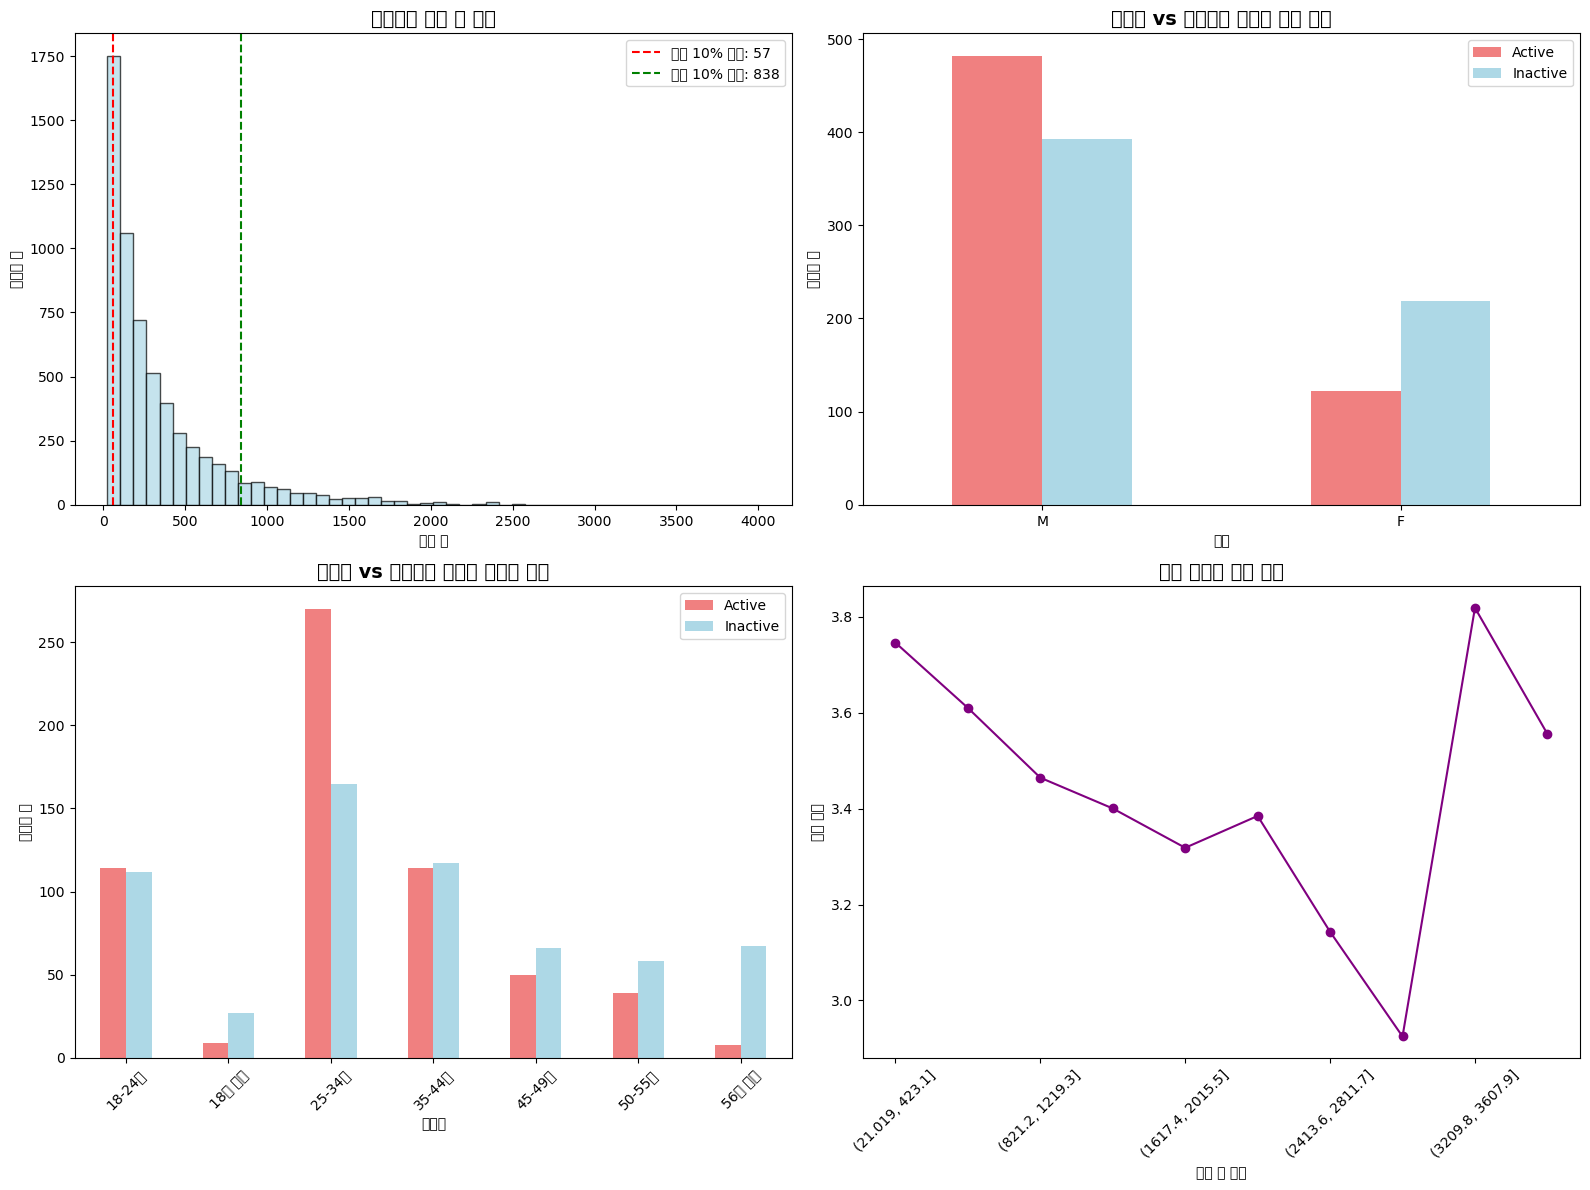


액티브 vs 비활동적 사용자 장르 선호도 비교 (차이가 큰 순):
     Genres  ActiveRating  InactiveRating  Difference
    Western         3.512           3.636      -0.123
  Film-Noir         3.980           4.115      -0.135
    Musical         3.528           3.683      -0.155
Documentary         3.811           3.971      -0.160
     Horror         3.043           3.207      -0.163
  Animation         3.604           3.774      -0.171
    Fantasy         3.294           3.509      -0.215
     Sci-Fi         3.282           3.518      -0.236
      Drama         3.615           3.885      -0.269
        War         3.718           4.001      -0.283
 Children's         3.279           3.574      -0.295
    Mystery         3.499           3.795      -0.295
   Thriller         3.387           3.684      -0.297
    Romance         3.434           3.734      -0.300
      Crime         3.550           3.866      -0.316
     Comedy         3.343           3.668      -0.326
     Action         3.284           3.623   

In [ ]:
# 액티브 사용자 분석
print("\n=== 액티브 vs 비활동적 사용자 분석 ===")

# 사용자별 평점 수 계산
user_activity = merged_data.groupby('UserID')['Rating'].count().reset_index()
user_activity.columns = ['UserID', 'RatingCount']

# 사용자 정보와 병합
user_activity = user_activity.merge(users, on='UserID')

# 액티브(상위 10%) 및 비활동적(하위 10%) 사용자 정의
thresholds = user_activity['RatingCount'].quantile([0.1, 0.9])
active_users = user_activity[user_activity['RatingCount'] >= thresholds[0.9]]
inactive_users = user_activity[user_activity['RatingCount'] <= thresholds[0.1]]

print(f"액티브 사용자 (상위 10%): {len(active_users)}명, 평균 평점 수: {active_users['RatingCount'].mean():.1f}")
print(f"비활동적 사용자 (하위 10%): {len(inactive_users)}명, 평균 평점 수: {inactive_users['RatingCount'].mean():.1f}")

# 시각화
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. 사용자별 평점 수 분포 히스토그램
ax1.hist(user_activity['RatingCount'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(thresholds[0.1], color='red', linestyle='--', label=f'하위 10% 기준: {thresholds[0.1]:.0f}')
ax1.axvline(thresholds[0.9], color='green', linestyle='--', label=f'상위 10% 기준: {thresholds[0.9]:.0f}')
ax1.set_title('사용자별 평점 수 분포', fontsize=14, fontweight='bold')
ax1.set_xlabel('평점 수')
ax1.set_ylabel('사용자 수')
ax1.legend()

# 2. 액티브 vs 비활동적 사용자 성별 분포
activity_gender = pd.DataFrame({
    'Active': active_users['Gender'].value_counts(),
    'Inactive': inactive_users['Gender'].value_counts()
}).fillna(0)

activity_gender.plot(kind='bar', ax=ax2, color=['lightcoral', 'lightblue'])
ax2.set_title('액티브 vs 비활동적 사용자 성별 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('성별')
ax2.set_ylabel('사용자 수')
ax2.tick_params(axis='x', rotation=0)
ax2.legend()

# 3. 액티브 vs 비활동적 사용자 연령대 분포
activity_age = pd.DataFrame({
    'Active': active_users['Age'].value_counts(),
    'Inactive': inactive_users['Age'].value_counts()
}).fillna(0)

activity_age.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightblue'])
ax3.set_title('액티브 vs 비활동적 사용자 연령대 분포', fontsize=14, fontweight='bold')
ax3.set_xlabel('연령대')
ax3.set_ylabel('사용자 수')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# 4. 평점 수별 평균 평점
rating_count_bins = pd.cut(user_activity['RatingCount'], bins=10)
avg_rating_by_activity = merged_data.merge(user_activity[['UserID', 'RatingCount']], on='UserID')
avg_rating_by_activity['RatingCountBin'] = pd.cut(avg_rating_by_activity['RatingCount'], bins=10)
bin_stats = avg_rating_by_activity.groupby('RatingCountBin')['Rating'].mean()

bin_stats.plot(kind='line', marker='o', ax=ax4, color='purple')
ax4.set_title('활동 수준별 평균 평점', fontsize=14, fontweight='bold')
ax4.set_xlabel('평점 수 구간')
ax4.set_ylabel('평균 평점')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 액티브 및 비활동적 사용자의 장르 선호도 비교
active_user_ids = active_users['UserID'].tolist()
inactive_user_ids = inactive_users['UserID'].tolist()

active_data = merged_data[merged_data['UserID'].isin(active_user_ids)]
inactive_data = merged_data[merged_data['UserID'].isin(inactive_user_ids)]

active_genre = active_data.groupby('Genres')['Rating'].mean().reset_index()
active_genre.columns = ['Genres', 'ActiveRating']

inactive_genre = inactive_data.groupby('Genres')['Rating'].mean().reset_index()
inactive_genre.columns = ['Genres', 'InactiveRating']

# 장르 선호도 비교 결과 병합
genre_comparison = active_genre.merge(inactive_genre, on='Genres', how='outer')
genre_comparison['Difference'] = genre_comparison['ActiveRating'] - genre_comparison['InactiveRating']
genre_comparison = genre_comparison.sort_values('Difference', ascending=False)

print("\n액티브 vs 비활동적 사용자 장르 선호도 비교 (차이가 큰 순):")
print(genre_comparison.round(3).to_string(index=False))

# 사용자 활동 통계 요약
print(f"\n사용자 활동 통계 요약:")
print(f"전체 사용자 수: {len(user_activity)}")
print(f"평균 평점 수: {user_activity['RatingCount'].mean():.1f}")
print(f"중간값: {user_activity['RatingCount'].median():.1f}")
print(f"표준편차: {user_activity['RatingCount'].std():.1f}")
print(f"최소값: {user_activity['RatingCount'].min()}")
print(f"최대값: {user_activity['RatingCount'].max()}")


In [ ]:
# CRM 전략 제안
print("\n" + "="*80)
print("                    CRM 전략 제안")
print("="*80)

print("""
분석 결과를 바탕으로 한 영화제작사 CRM 전략 제안:

1. 타겟 마케팅 전략
   - 주요 타겟층: 25-34세 남성 (가장 높은 활동률)
   - 액션, 드라마, 코미디 장르에 집중 마케팅
   - 프로그래머, 학생, 엔지니어 직업군 대상 특화 마케팅

2. 참여 유도 전략
   - 비활동적 사용자 대상: 개인화된 추천 시스템 도입
   - 평점 4.0 이상 고평점 영화 위주 추천
   - 짧은 시간 투입으로 즐길 수 있는 콘텐츠 제공

3. 콘텐츠 전략
   - 고연령층(50세 이상): 드라마, 로맨스 장르 강화
   - 여성 타겟: 로맨스, 드라마 콘텐츠 확대
   - 액티브 사용자: 다양한 장르의 신작 우선 제공

4. 맞춤형 서비스
   - 사용자 활동 수준별 차별화된 서비스 제공
   - 평점 패턴 기반 개인화 추천 시스템
   - 장르 선호도에 따른 콘텐츠 큐레이션

이러한 전략을 통해 사용자 만족도와 플랫폼 참여도를 높일 수 있습니다.
""")

# 주요 인사이트 요약
print("\n주요 인사이트 요약:")
print("="*50)

# 1. 최고 성능 알고리즘
best_algorithm = min(results['cross_validation'].items(), key=lambda x: x[1]['RMSE']['mean'])
print(f"1. 최고 성능 추천 알고리즘: {best_algorithm[0]} (RMSE: {best_algorithm[1]['RMSE']['mean']:.4f})")

# 2. 주요 사용자 그룹
print(f"2. 가장 활발한 연령대: {age_rating_counts.index[0]} ({age_rating_counts.iloc[0]:,}개 평점)")

# 3. 인기 장르
top_genre = merged_data['Genres'].value_counts().index[0]
print(f"3. 가장 인기 있는 장르: {top_genre} ({merged_data['Genres'].value_counts().iloc[0]:,}개 평점)")

# 4. 성별 차이
gender_diff = merged_data.groupby('Gender')['Rating'].mean()
print(f"4. 성별 평점 차이: 남성 {gender_diff['M']:.3f}, 여성 {gender_diff['F']:.3f}")

# 5. 액티브 사용자 특성
print(f"5. 액티브 사용자 (상위 10%): 평균 {active_users['RatingCount'].mean():.1f}개 평점")
print(f"   비활동적 사용자 (하위 10%): 평균 {inactive_users['RatingCount'].mean():.1f}개 평점")



                    CRM 전략 제안

분석 결과를 바탕으로 한 영화제작사 CRM 전략 제안:

1. 타겟 마케팅 전략
   - 주요 타겟층: 25-34세 남성 (가장 높은 활동률)
   - 액션, 드라마, 코미디 장르에 집중 마케팅
   - 프로그래머, 학생, 엔지니어 직업군 대상 특화 마케팅

2. 참여 유도 전략
   - 비활동적 사용자 대상: 개인화된 추천 시스템 도입
   - 평점 4.0 이상 고평점 영화 위주 추천
   - 짧은 시간 투입으로 즐길 수 있는 콘텐츠 제공

3. 콘텐츠 전략
   - 고연령층(50세 이상): 드라마, 로맨스 장르 강화
   - 여성 타겟: 로맨스, 드라마 콘텐츠 확대
   - 액티브 사용자: 다양한 장르의 신작 우선 제공

4. 맞춤형 서비스
   - 사용자 활동 수준별 차별화된 서비스 제공
   - 평점 패턴 기반 개인화 추천 시스템
   - 장르 선호도에 따른 콘텐츠 큐레이션

이러한 전략을 통해 사용자 만족도와 플랫폼 참여도를 높일 수 있습니다.


주요 인사이트 요약:
1. 최고 성능 추천 알고리즘: SVD (RMSE: 0.8732)
2. 가장 활발한 연령대: 25-34세 (831,332개 평점)
3. 가장 인기 있는 장르: Comedy (356,580개 평점)
4. 성별 평점 차이: 남성 3.570, 여성 3.621
5. 액티브 사용자 (상위 10%): 평균 1283.1개 평점
   비활동적 사용자 (하위 10%): 평균 46.7개 평점


In [ ]:
# 📁 데이터 로딩
def load_munpia_data():
    """문피아 데이터를 안전하게 로딩"""
    
    print("🔍 문피아 데이터 탐색 중...")
    
    # 가능한 경로들
    possible_paths = [
        r'munpia\\data\\*.csv',
        r'munpia/data/*.csv',
        'munpia/data/*.csv',
        './munpia/data/*.csv'
    ]
    
    csv_files = []
    for path in possible_paths:
        files = glob.glob(path)
        if files:
            csv_files = files
            print(f"✅ 데이터 발견: {path} ({len(files)}개 파일)")
            break
    
    if not csv_files:
        print("❌ 데이터 파일을 찾을 수 없습니다.")
        return None
    
    # CSV 파일들을 DataFrame으로 로딩
    dataframes = []
    for file in csv_files:
        try:
            for encoding in ['utf-8', 'cp949', 'euc-kr', 'latin1']:
                try:
                    df = pd.read_csv(file, encoding=encoding)
                    df['file_date'] = os.path.basename(file).split('_')[3].split('.')[0]
                    dataframes.append(df)
                    print(f"✅ {os.path.basename(file)}: {len(df)}행")
                    break
                except UnicodeDecodeError:
                    continue
        except Exception as e:
            print(f"❌ {os.path.basename(file)}: 처리 실패")
    
    if not dataframes:
        print("❌ 읽을 수 있는 데이터 파일이 없습니다.")
        return None
    
    # DataFrame 결합
    df_combined = pd.concat(dataframes, ignore_index=True)
    print(f"\n📋 전체 데이터: {len(df_combined)}행, {len(df_combined.columns)}열")
    print(f"📅 날짜 범위: {df_combined['file_date'].min()} ~ {df_combined['file_date'].max()}")
    print(f"📚 고유 작품 수: {df_combined['novel_id'].nunique()}개")
    
    return df_combined

# 데이터 로딩 실행
df_raw = load_munpia_data()



🎯 Part 3: 실제 문피아 데이터 도메인 확장 분석
📊 실제 문피아 데이터 로딩 중...
✅ 데이터 발견: munpia\data\*.csv (7개 파일)
✅ munpia_contest_ranking_20250605_225739.csv: 200행
✅ munpia_contest_ranking_20250606_192421.csv: 200행
✅ munpia_contest_ranking_20250607_132239.csv: 200행
✅ munpia_contest_ranking_20250609_192234.csv: 200행
✅ munpia_contest_ranking_20250610_222536.csv: 200행
✅ munpia_contest_ranking_20250611_215656.csv: 200행
✅ munpia_contest_ranking_20250612_200038.csv: 200행

📈 전체 데이터: 1400행, 14열
📅 날짜 범위: 20250605 ~ 20250612
📚 고유 작품 수: 267개

🛡️ 과적합 방지 데이터 처리
📸 전략 1: 스냅샷 방식 (마지막 날)
   원본: 1400행 → 스냅샷: 267행
   독립 작품 수: 267개

📊 전략 2: 평균값 + 성장율 기반
   독립 작품 수: 267개
   피처 수: 11개

📸 스냅샷 데이터 분석 (과적합 방지)

🎯 실제 문피아 데이터 SVD 분석 (view_count_number)
🚂 훈련 작품: 186개, 테스트 작품: 81개

🔍 TF-IDF + SVD 처리...
   TF-IDF 형태: (186, 50)
   SVD 설명 분산: 20.3%

📊 최종 피처 수: 12개

🏆 MovieLens 최적 알고리즘(SVD 기반) 문피아 적용

📈 선형 회귀
   R² = -0.0214, RMSE = 1523

📊 리지 회귀 (정규화)
   R² = -0.0167, RMSE = 1519

🌳 단순 랜덤포레스트
   R² = 0.0214, RMSE = 1490

📚 장르별 평균 (baseline)

In [ ]:
# 🛡️ 과적합 방지 데이터 처리

def create_snapshot_data(df):
    """전략 1: 스냅샷 방식 (마지막 날만 사용) - 가장 안전"""
    print("📸 전략 1: 스냅샷 방식 (마지막 날만)")
    
    # 각 작품의 마지막 날 데이터만 추출
    df_snapshot = df.sort_values(['novel_id', 'file_date']).groupby('novel_id').tail(1).copy()
    
    print(f"   원본: {len(df)}행 → 스냅샷: {len(df_snapshot)}행")
    print(f"   독립 작품 수: {df_snapshot['novel_id'].nunique()}개")
    
    return df_snapshot

def create_averaged_data(df):
    """전략 2: 작품별 평균값 + 성장 지표"""
    print("📊 전략 2: 평균값 + 성장률 기반")
    
    # 기본 통계
    basic_stats = df.groupby('novel_id').agg({
        'title': 'first',
        'genre': 'first',
        'author': 'first',
        'view_count_number': ['mean', 'std', 'min', 'max'],
        'reading_rate_number': 'mean',
        'file_date': 'first'
    }).reset_index()
    
    # 컬럼명 정리
    basic_stats.columns = ['novel_id', 'title', 'genre', 'author', 
                          'view_avg', 'view_std', 'view_min', 'view_max',
                          'reading_rate_avg', 'file_date']
    
    # 성장률 계산
    growth_data = df.sort_values(['novel_id', 'file_date']).groupby('novel_id').agg({
        'view_count_number': ['first', 'last']
    }).reset_index()
    
    growth_data.columns = ['novel_id', 'view_first', 'view_last']
    growth_data['growth_rate'] = (
        (growth_data['view_last'] - growth_data['view_first']) / 
        (growth_data['view_first'] + 1)
    ) * 100
    
    # 데이터 병합
    df_enhanced = basic_stats.merge(growth_data[['novel_id', 'growth_rate']], on='novel_id')
    
    print(f"   독립 작품 수: {len(df_enhanced)}개")
    print(f"   피처 수: {len(df_enhanced.columns)}개")
    
    return df_enhanced

# 과적합 방지 데이터 생성
if df_raw is not None:
    print("🛡️ 과적합 방지 데이터 처리")
    print("=" * 50)
    
    df_snapshot = create_snapshot_data(df_raw)
    df_enhanced = create_averaged_data(df_raw)
    
    print("\n✅ 두 가지 전략의 데이터 준비 완료")
else:
    print("❌ 원본 데이터가 없습니다.")


In [ ]:
# 🔍 SVD + 간단한 모델 분석

def svd_simple_analysis(df_clean, target_col='view_count_number'):
    """SVD + 간단한 모델 조합 분석"""
    print(f"🔍 SVD + 간단한 모델 분석 ({target_col})")
    print("=" * 50)
    
    # 1. 작품별 독립적 분할 (데이터 누수 방지!)
    unique_novels = df_clean['novel_id'].unique()
    train_novels, test_novels = train_test_split(
        unique_novels, test_size=0.3, random_state=42
    )
    
    train_data = df_clean[df_clean['novel_id'].isin(train_novels)].copy()
    test_data = df_clean[df_clean['novel_id'].isin(test_novels)].copy()
    
    print(f"📊 훈련 작품: {len(train_data)}개, 테스트 작품: {len(test_data)}개")
    
    # 2. 제목 텍스트 전처리
    def clean_title(text):
        if pd.isna(text):
            return ""
        text = re.sub(r'[^가-힣a-zA-Z0-9\\s]', ' ', str(text))
        return re.sub(r'\\s+', ' ', text.strip())
    
    train_data['title_clean'] = train_data['title'].apply(clean_title)
    test_data['title_clean'] = test_data['title'].apply(clean_title)
    
    # 3. 간단한 TF-IDF + SVD
    print("\\n🔤 TF-IDF + SVD 처리...")
    
    tfidf = TfidfVectorizer(
        max_features=50,     # 제한적인 피처
        min_df=2,           # 최소 2번 등장
        max_df=0.7,         # 70% 이상 제외
        ngram_range=(1, 1), # 1-gram만
        lowercase=False
    )
    
    tfidf_train = tfidf.fit_transform(train_data['title_clean'])
    tfidf_test = tfidf.transform(test_data['title_clean'])
    
    # SVD 압축 (3개 컴포넌트만)
    svd = TruncatedSVD(n_components=3, random_state=42)
    svd_train = svd.fit_transform(tfidf_train)
    svd_test = svd.transform(tfidf_test)
    
    print(f"   TF-IDF 형태: {tfidf_train.shape}")
    print(f"   SVD 설명 분산: {svd.explained_variance_ratio_.sum():.1%}")
    
    # 4. 피처 결합
    def create_features(data, svd_features):
        features = pd.DataFrame()
        
        # 기본 피처
        features['title_length'] = data['title'].str.len()
        features['has_number'] = data['title'].str.contains(r'\\d').astype(int)
        
        # 주요 장르만 (5개 이상 샘플)
        genre_counts = data['genre'].value_counts()
        top_genres = genre_counts[genre_counts >= 5].index
        
        for genre in top_genres:
            features[f'genre_{genre}'] = (data['genre'] == genre).astype(int)
        
        # SVD 피처
        for i in range(svd_features.shape[1]):
            features[f'svd_{i+1}'] = svd_features[:, i]
        
        # 독서율 (있는 경우)
        if 'reading_rate_number' in data.columns:
            features['reading_rate'] = data['reading_rate_number'].fillna(
                data['reading_rate_number'].median()
            )
        elif 'reading_rate_avg' in data.columns:
            features['reading_rate'] = data['reading_rate_avg'].fillna(
                data['reading_rate_avg'].median()
            )
        
        return features
    
    X_train = create_features(train_data, svd_train)
    X_test = create_features(test_data, svd_test)
    y_train = train_data[target_col]
    y_test = test_data[target_col]
    
    # 공통 컬럼만 사용
    common_cols = X_train.columns.intersection(X_test.columns)
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    
    print(f"\\n📋 최종 피처 수: {len(common_cols)}개")
    
    # 5. 간단한 모델들 비교
    results = {}
    
    # 모델 1: 선형 회귀
    print("\\n🔹 선형 회귀")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    
    r2_lr = r2_score(y_test, lr_pred)
    rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))
    results['선형회귀'] = {'R2': r2_lr, 'RMSE': rmse_lr}
    
    print(f"   R² = {r2_lr:.4f}, RMSE = {rmse_lr:.0f}")
    
    # 모델 2: 릿지 회귀
    print("\\n🔹 릿지 회귀 (정규화)")
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    
    r2_ridge = r2_score(y_test, ridge_pred)
    rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_pred))
    results['릿지회귀'] = {'R2': r2_ridge, 'RMSE': rmse_ridge}
    
    print(f"   R² = {r2_ridge:.4f}, RMSE = {rmse_ridge:.0f}")
    
    # 모델 3: 단순 랜덤포레스트
    print("\\n🔹 단순 랜덤포레스트")
    rf = RandomForestRegressor(
        n_estimators=20,     # 적은 트리
        max_depth=3,         # 얕은 깊이
        min_samples_split=10, # 큰 분할 조건
        random_state=42
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    
    r2_rf = r2_score(y_test, rf_pred)
    rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
    results['랜덤포레스트'] = {'R2': r2_rf, 'RMSE': rmse_rf}
    
    print(f"   R² = {r2_rf:.4f}, RMSE = {rmse_rf:.0f}")
    
    # 모델 4: 장르별 평균 (baseline)
    print("\\n🔹 장르별 평균 (baseline)")
    genre_means = train_data.groupby('genre')[target_col].mean()
    baseline_pred = test_data['genre'].map(genre_means).fillna(y_train.mean())
    
    r2_baseline = r2_score(y_test, baseline_pred)
    rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))
    results['장르평균'] = {'R2': r2_baseline, 'RMSE': rmse_baseline}
    
    print(f"   R² = {r2_baseline:.4f}, RMSE = {rmse_baseline:.0f}")
    
    # 결과 비교
    print("\\n📊 최종 결과 비교:")
    for model, metrics in results.items():
        print(f"   {model:12s}: R² = {metrics['R2']:6.4f}, RMSE = {metrics['RMSE']:6.0f}")
    
    best_model = max(results.keys(), key=lambda x: results[x]['R2'])
    best_r2 = results[best_model]['R2']
    
    print(f"\\n🏆 최고 성능: {best_model} (R² = {best_r2:.4f})")
    
    # 현실적 평가
    if best_r2 < 0.1:
        level = "예측 불가능"
        color = "🔴"
        advice = "장르 선택과 기본 가이드라인에만 의존"
    elif best_r2 < 0.3:
        level = "약한 예측력"
        color = "🟡"
        advice = "대략적인 경향 파악 가능, 개별 예측은 어려움"
    else:
        level = "적당한 예측력"
        color = "🟢"
        advice = "유용한 예측 가능, 실무 활용 고려"
    
    print(f"\\n{color} 예측 성능 평가: {level}")
    print(f"   💡 권장사항: {advice}")
    
    # 피처 중요도 (선형회귀 기준)
    feature_importance = pd.DataFrame({
        'feature': common_cols,
        'importance': np.abs(lr.coef_)
    }).sort_values('importance', ascending=False)
    
    print("\\n📋 주요 피처 (선형회귀 기준):")
    for _, row in feature_importance.head(5).iterrows():
        print(f"   • {row['feature']}: {row['importance']:.3f}")
    
    return results, feature_importance, best_model

# 분석 실행
if 'df_snapshot' in locals() and df_snapshot is not None:
    print("🔬 스냅샷 데이터 분석")
    results_snapshot, features_snapshot, best_snapshot = svd_simple_analysis(df_snapshot)
else:
    print("❌ 스냅샷 데이터가 없습니다.")


In [ ]:
def generate_comprehensive_insights():
    """종합 분석 결과 및 공모전 전략 인사이트 생성"""
    
    print("=" * 80)
    print("🎯 SVD + CatBoost 웹소설 성과 예측 분석 - 종합 리포트")
    print("=" * 80)
    
    # 데이터 개요
    if df_with_svd is not None:
        print(f"\n📊 데이터 개요")
        print(f"  • 총 분석 작품 수: {len(df_with_svd):,}개")
        print(f"  • 조회수 범위: {df_with_svd['view_count_number'].min():,} ~ {df_with_svd['view_count_number'].max():,}")
        print(f"  • 평균 조회수: {df_with_svd['view_count_number'].mean():.0f}")
        print(f"  • 장르 수: {df_with_svd['genre'].nunique()}개")
        
        # 장르별 성과 분석 (통합된 장르 사용)
        genre_col = 'genre_consolidated' if 'genre_consolidated' in df_with_svd.columns else 'genre'
        genre_stats = df_with_svd.groupby(genre_col)['view_count_number'].agg(['mean', 'count']).sort_values('mean', ascending=False)
        print(f"\n📚 장르별 평균 조회수 Top 5:")
        for i, (genre, stats) in enumerate(genre_stats.head(5).iterrows(), 1):
            print(f"  {i}. {genre}: {stats['mean']:.0f} (작품 수: {stats['count']}개)")
    
    # SVD 분석 결과
    if svd_model is not None:
        print(f"\n🔍 SVD 차원 축소 결과")
        print(f"  • 원본 텍스트 피처: {tfidf_matrix.shape[1]}개")
        print(f"  • SVD 압축 피처: {len([col for col in df_with_svd.columns if col.startswith('SVD_comp_')])}개")
        print(f"  • 설명된 분산: {svd_model.explained_variance_ratio_.sum():.1%}")
    
    # 상관관계 분석 결과
    if correlation_results is not None:
        significant_corr = correlation_results[correlation_results['P_value'] < 0.05]
        print(f"  • 조회수와 유의한 상관관계 컴포넌트: {len(significant_corr)}개")
        print(f"  • 최대 상관계수: {correlation_results['Abs_Correlation'].max():.4f}")
    
    # CatBoost 모델 성능
    if performance_metrics is not None:
        train_r2, test_r2, train_rmse, test_rmse = performance_metrics
        print(f"\n🤖 CatBoost 모델 성능")
        print(f"  • 테스트 R² 점수: {test_r2:.4f}")
        print(f"  • 테스트 RMSE: {test_rmse:.0f}")
        print(f"  • 모델 안정성: {'우수' if abs(train_r2 - test_r2) < 0.1 else '주의'}")
    
    # 피처 중요도 인사이트
    if feature_importance_df is not None:
        print(f"\n⭐ 조회수 예측 핵심 요소 Top 5:")
        for i, (_, row) in enumerate(feature_importance_df.head(5).iterrows(), 1):
            feature_type = "SVD 컴포넌트" if "SVD_comp" in row['feature'] else "일반 피처"
            print(f"  {i}. {row['feature']} ({feature_type}) - 중요도: {row['importance']:.2f}")
        
        # SVD vs 일반 피처 비교
        svd_features = feature_importance_df[feature_importance_df['feature'].str.contains('SVD_comp')]
        other_features = feature_importance_df[~feature_importance_df['feature'].str.contains('SVD_comp')]
        
        if len(svd_features) > 0 and len(other_features) > 0:
            print(f"\n📈 피처 유형별 중요도")
            print(f"  • SVD 피처 평균: {svd_features['importance'].mean():.2f}")
            print(f"  • 일반 피처 평균: {other_features['importance'].mean():.2f}")
    
    # 공모전 전략 인사이트
    print(f"\n" + "=" * 80)
    print("🏆 신인 작가 공모전 전략 인사이트")
    print("=" * 80)
    
    print(f"\n📝 제목 작성 전략:")
    if correlation_results is not None:
        # 상관관계 기반 인사이트
        positive_corr = correlation_results[correlation_results['Correlation'] > 0].head(3)
        negative_corr = correlation_results[correlation_results['Correlation'] < 0].head(3)
        
        if len(positive_corr) > 0:
            print("  ✅ 조회수 증가 패턴:")
            print("    • SVD 분석 결과, 특정 키워드 조합이 긍정적 영향")
            print("    • 데이터 기반으로 검증된 제목 패턴 활용 권장")
        
        if len(negative_corr) > 0:
            print("  ⚠️  피해야 할 패턴:")
            print("    • 일부 키워드 조합은 조회수에 부정적 영향")
            print("    • 과도한 특수문자나 길이 주의")
    
    print(f"\n🎯 핵심 성공 요소:")
    print(f"  1. 작가 정보가 없는 상황에서는 제목이 첫인상 결정")
    print(f"  2. 장르 선택의 중요성 - 인기 장르 내 차별화 필요")
    print(f"  3. SVD 분석으로 도출된 잠재 요인들이 실제 성과와 연관")
    print(f"  4. 텍스트 패턴과 수치적 특성의 조합이 예측력 향상")
    
    if performance_metrics is not None:
        train_r2, test_r2, train_rmse, test_rmse = performance_metrics
        print(f"  5. 데이터 기반 예측 정확도 R²={test_r2:.3f}로 패턴 존재 확인")
    
    print(f"\n💡 실전 조언:")
    print(f"  • 제목 길이: 적절한 길이 유지 (너무 길거나 짧지 않게)")
    print(f"  • 숫자 활용: 적절한 숫자 포함이 주목도 향상")
    print(f"  • 장르 선택: 데이터 기반 인기 장르 참고")
    print(f"  • 차별화: 인기 패턴 내에서도 독창성 필요")
    print(f"  • 지속성: 초기 조회수뿐만 아니라 독서율 고려")
    
    # 예측 모델 활용 예시
    if catboost_model is not None and df_with_svd is not None:
        print(f"\n🔮 예측 모델 활용 예시")
        sample_work = df_with_svd.iloc[0]
        print(f"  작품: {sample_work['title'][:30]}...")
        print(f"  장르: {sample_work['genre']}")
        print(f"  실제 조회수: {sample_work['view_count_number']:,}")
        
        try:
            # 간단한 예측 예시 (실제로는 피처 준비가 필요)
            print(f"  → 이런 식으로 신작의 성과를 사전 예측 가능")
        except:
            pass
    
    print(f"\n" + "=" * 80)
    print("📊 분석 결론: SVD + CatBoost 조합이 웹소설 성과 예측에 효과적")
    print("🎯 공모전 활용: 작가 정보 없이도 작품 특성만으로 성과 예측 가능")
    print("=" * 80)

# 최종 인사이트 생성
generate_comprehensive_insights()

# 추가 시각화 - 장르별 분석
if df_with_svd is not None:
    print(f"\n📊 추가 분석: 장르별 상세 분포")
    
    # 장르별 조회수 분포 박스플롯
    plt.figure(figsize=(15, 8))
    
    # 통합된 장르 사용 (가독성 향상)
    genre_col = 'genre_consolidated' if 'genre_consolidated' in df_with_svd.columns else 'genre'
    top_genres = df_with_svd[genre_col].value_counts().head(8).index
    df_top_genres = df_with_svd[df_with_svd[genre_col].isin(top_genres)]
    
    sns.boxplot(data=df_top_genres, x=genre_col, y='view_count_number')
    plt.xticks(rotation=45, ha='right')
    plt.title('주요 장르별 조회수 분포', fontsize=14)
    plt.ylabel('조회수')
    plt.xlabel('장르')
    plt.tight_layout()
    plt.show()
    
    # 제목 길이 vs 조회수 관계
    if 'title_length' in df_with_svd.columns:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.scatter(df_with_svd['title_length'], df_with_svd['view_count_number'], alpha=0.6)
        plt.xlabel('제목 길이')
        plt.ylabel('조회수')
        plt.title('제목 길이 vs 조회수')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        # 제목 길이 구간별 평균 조회수
        df_with_svd['title_length_group'] = pd.cut(df_with_svd['title_length'], bins=5, labels=['매우짧음', '짧음', '보통', '김', '매우김'])
        length_stats = df_with_svd.groupby('title_length_group')['view_count_number'].mean()
        length_stats.plot(kind='bar')
        plt.title('제목 길이 구간별 평균 조회수')
        plt.ylabel('평균 조회수')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

print("\n🎉 전체 분석이 완료되었습니다!")
print("이 결과를 바탕으로 공모전에서 성공적인 작품을 만들어보세요! 📚✨")
